# 합격/불합격 분류 모델
#### 60170029 이종언

# 1) 데이터 로딩
### 1-1) 라이브러리 불러오기

In [37]:
#pandas, numpy 호출
import pandas as pd 
import numpy as np
#sklearn 호출
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets
#sklearn 스플리터
from sklearn.model_selection import train_test_split #X,Y값 Splitter
#의사결정나무 라이브러리
from sklearn.tree import DecisionTreeClassifier #의사결정나무
from sklearn.model_selection import GridSearchCV #의사결정나무 최적깊이값 서치용
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001), #불순도 범위
          'max_depth': range(3, 30, 1), #깊이 탐색 범위
          'min_samples_split': range(2, 100, 10) #샘플split 범위
         }

### 1-2) 데이터프레임으로 데이터 읽어오기

In [38]:
df = pd.read_csv("student.csv") #csv 데이터 입력, 칼럼인덱스 미사용
df.head() #불러온 데이터프레임 상위 8개값 호출

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,f,19,Korea,불합격
1,660.0,3.67,3,f,18,Korea,NaN
2,800.0,4.00,1,m,19,Korea,합격
3,NaN,3.19,4,m,19,Korea,합격
4,520.0,2.93,4,f,19,Korea,불합격


# 2) 데이터 확인

## 결측치 확인

In [39]:
df.isnull().sum()

gre            2
gpa            2
rank           0
sex            0
age            0
nationality    0
admission      2
dtype: int64

#### gre 칼럼과 gpa 칼럼, admission 칼럼에 2개씩 결측치가 확인된다.

In [40]:
print('Column 수 : %s' % df.shape[0]) #칼럼수 카운트
print('Row 수 : %s' % df.shape[1]) #레코드수 카운트
print('\n[Column 리스트]\n',df.columns.tolist()) #칼럼 뭐가있는지 확인 (df.columns.unique() 도 가능)

print('\n[데이터프레임 정보]')
df.info() #데이터프레임의 정보 표시

print('\n[통계]')
df.describe() #데이터프레임의 각 칼럼의 통계정보 표시

# [각 칼럼 이해]
# gre - GRE 점수
# gpa - 학점
# rank – 등급
# sex – 성별
# age – 나이S
# nationality – 국적
# admission – 합격 여부


Column 수 : 400
Row 수 : 7

[Column 리스트]
 ['gre', 'gpa', 'rank', 'sex', 'age', 'nationality', 'admission']

[데이터프레임 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gre          398 non-null    float64
 1   gpa          398 non-null    float64
 2   rank         400 non-null    int64  
 3   sex          400 non-null    object 
 4   age          400 non-null    int64  
 5   nationality  400 non-null    object 
 6   admission    398 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 22.0+ KB

[통계]


,gre,gpa,rank,age
count,398.000000,398.000000,400.00000,400.000000
mean,587.889447,3.389497,2.48500,19.025000
std,115.599708,0.381268,0.94446,0.809948
min,220.000000,2.260000,1.00000,17.000000
25%,520.000000,3.130000,2.00000,19.000000
50%,580.000000,3.395000,2.00000,19.000000
75%,660.000000,3.670000,3.00000,19.000000
max,800.000000,4.000000,4.00000,22.000000


#### sex, nationality, admission 값은 현재 object 로 입력되어있어 수치화가 필요하다.
#### gre 와 gpa 값은 연속된 실수값이며 rank 값과 age 값은 연속된 정수값이기에 의사결정나무모델 사용에 크게 적합하지는 않다.

# 3) 데이터 전처리

## 3-1) sex 칼럼 수치화 (남자 : 0 / 여자 : 1)

In [41]:
df["sex"] = df.sex.map(lambda x: 0 if x=='m' else 1) #람다 함수로 매핑
df.head(6)

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,1,19,Korea,불합격
1,660.0,3.67,3,1,18,Korea,NaN
2,800.0,4.00,1,0,19,Korea,합격
3,NaN,3.19,4,0,19,Korea,합격
4,520.0,2.93,4,1,19,Korea,불합격
5,760.0,3.00,2,1,19,Korea,합격


## 3-2) nationality 칼럼 수치화

In [42]:
print(df['nationality'].unique())

['Korea' 'Japan' 'China' 'Mongol' 'Vietnam' 'India']


In [43]:
divnat = {'Korea':0, 'Japan':1, 'China':2, 'Mongol':3, 'Vietnam':4, 'India':5} #Dictionary 로 매핑
df["nationality"] = df.nationality.map(divnat)

#nationality 결과 확인
dftemp0 = df.drop_duplicates(subset='nationality', keep='first') #nationality 칼럼 기준 distinct 값만 사용
dftemp0

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,1,19,0,불합격
10,800.0,4.00,4,0,18,1,불합격
78,540.0,3.12,1,1,19,2,불합격
130,620.0,3.17,2,1,19,3,합격
148,480.0,2.91,1,0,19,4,합격
360,520.0,4.00,1,0,18,5,합격


#### nationality 칼럼 매핑 완료

## 3-3) admission 칼럼 수치화 (불합격 : 0 / 합격 : 1)

#### admission 칼럼은 이번에 gre 및 gpa 결측치 채우기에 사용할 예정이므로 목표변수 뿐 아니라 선형회귀모델의 속성으로도 사용되므로 편의상 수치화하였다.

In [44]:
divadm = {'불합격':0, '합격':1} #Dictionary 로 매핑
df["admission"] = df.admission.map(divadm)
df.head(5)

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,1,19,0,0.0
1,660.0,3.67,3,1,18,0,NaN
2,800.0,4.00,1,0,19,0,1.0
3,NaN,3.19,4,0,19,0,1.0
4,520.0,2.93,4,1,19,0,0.0


## 3-4) 수치화 결과 확인

In [45]:
print('\n[데이터프레임 정보]')
df.info() #데이터프레임의 정보 표시


[데이터프레임 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gre          398 non-null    float64
 1   gpa          398 non-null    float64
 2   rank         400 non-null    int64  
 3   sex          400 non-null    int64  
 4   age          400 non-null    int64  
 5   nationality  400 non-null    int64  
 6   admission    398 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 22.0 KB


#### 모든 칼럼이 수치화되었다.

## 3-5 ) 탐색적 데이터 분석과정(EDA) 을 통한 결측치 보간

In [46]:
# gre - 대학원 입학 시험 점수
# gpa - 대학 학점
# rank – 학생 등급
# sex – 성별
# age – 나이
# nationality – 국적
# admission – 합격 여부

### 합격과 불합격 비율

In [47]:
df['admission'].value_counts()

0.0    272
1.0    126
Name: admission, dtype: int64

약 46.32%의 합격률을 보이고 있다.

#### Rank 에 따른 합격자 비율

In [48]:
df.groupby('rank')['admission'].value_counts()

rank  admission
1     1.0          33
      0.0          28
2     0.0          97
      1.0          54
3     0.0          92
      1.0          27
4     0.0          55
      1.0          12
Name: admission, dtype: int64

<AxesSubplot:>

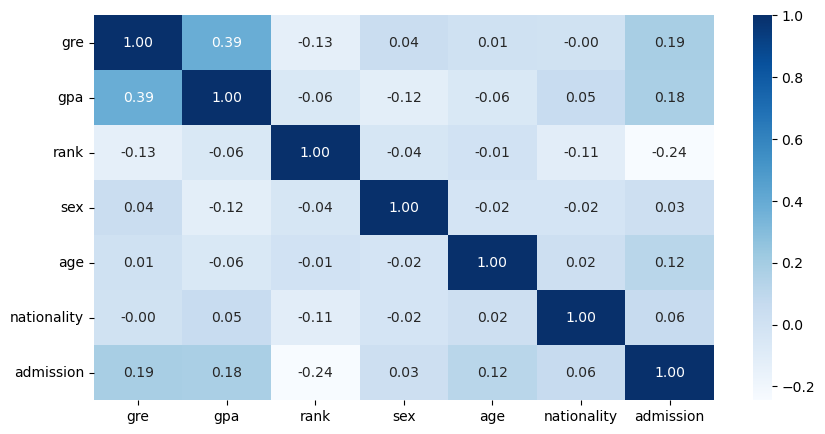

In [49]:
import seaborn as sns #seaborn 호출
import matplotlib.pyplot as plot #plot 호출
plot.figure(figsize=(10,5)) #10x5 크기로 설정
eda_corr = df.corr()
sns.heatmap(data = eda_corr, annot=True, fmt = '0.2f', cmap='Blues')
#상관계수분석 기반 heatmap 작성, 수치(annot) 표시, 표시형식은 소숫점 2자리까지, 컬러는 블루

#### 시험 합격/불합격 여부와 연관이 큰 속성은 Rank, gre, gpa, age 순이다..

##### 0) 합격/불합격 값이 결측치인 행을 gre, gpa 값을 예측하는 데 사용하기로 하여 아래의 코드는 미사용한다.
##### df = df.dropna(axis=0, subset=['admission']) // admission 칼럼에 결측치가 있는 행 모두 삭제
##### 1) gre 와 gpa 는 연속된 값이므로 admission 과 rank 로 그룹지어 해당 학생이 속한 그룹의 중간값으로 결측치를 채울 수 있다.
##### df = df.groupby(['admission', 'rank'])['gre'].apply(lambda x: x.fillna(x.median()))
##### 2) gre/gpa 값은 레코드 순서대로 연속되지 않기에 interpolate() 함수를 사용하여 선형보간법을 사용하기 적절하지 않다.
#### 
#### gre값은 gpa 값과 상관계수가 높으며, gpa 값은 gre 값과 상관계수가 없다.
#### 또한 gre값과 gpa 값은 float 타입의 연속값이다.
#### 이에 gre 에는 gpa, admision 값을, gpa 에는 gre,admission 값을 이용하여 선형회귀모델을 만들어 대체하기로 하였다.

## 3-5-1) gpa, admission 값으로 gre 결측치 채우기

In [50]:
df.head()

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,1,19,0,0.0
1,660.0,3.67,3,1,18,0,NaN
2,800.0,4.00,1,0,19,0,1.0
3,NaN,3.19,4,0,19,0,1.0
4,520.0,2.93,4,1,19,0,0.0


In [51]:
from sklearn import linear_model #선형회귀모델 호출
X0 = df.dropna(axis=0)[['gpa','admission']] #gpa와 admission 칼럼의 결측지가 있는 레코드를 제거한 뒤 속성값으로 활용
Y0 = df.dropna(axis=0)['gre'] #gre값을 목표변수로 활용
#numpy array 로 변환
X0 = np.array(X0.iloc[:,:])
Y0 = np.array(Y0.iloc[:])
print('[X속성]\n',X0)
print('[Y목표변수]\n',Y0)

[X속성]
 [[3.61 0.  ]
 [4.   1.  ]
 [2.93 0.  ]
 [3.   1.  ]
 [2.98 1.  ]
 [3.08 0.  ]
 [3.39 1.  ]
 [3.92 0.  ]
 [4.   0.  ]
 [3.22 0.  ]
 [4.   1.  ]
 [3.08 0.  ]
 [4.   1.  ]
 [3.44 0.  ]
 [3.87 0.  ]
 [2.56 0.  ]
 [3.75 0.  ]
 [3.81 1.  ]
 [3.63 1.  ]
 [2.82 0.  ]
 [3.19 0.  ]
 [3.35 1.  ]
 [3.66 1.  ]
 [3.61 1.  ]
 [3.74 1.  ]
 [3.22 1.  ]
 [3.78 0.  ]
 [3.35 0.  ]
 [3.4  0.  ]
 [4.   1.  ]
 [3.14 0.  ]
 [3.05 0.  ]
 [3.25 0.  ]
 [2.9  0.  ]
 [3.13 1.  ]
 [2.68 1.  ]
 [2.42 0.  ]
 [3.32 1.  ]
 [3.15 1.  ]
 [3.31 0.  ]
 [2.94 0.  ]
 [3.45 1.  ]
 [3.46 1.  ]
 [2.97 0.  ]
 [2.48 0.  ]
 [3.35 0.  ]
 [3.86 0.  ]
 [3.13 0.  ]
 [3.37 0.  ]
 [3.27 1.  ]
 [3.34 0.  ]
 [4.   1.  ]
 [3.19 0.  ]
 [2.94 0.  ]
 [3.65 0.  ]
 [2.82 0.  ]
 [3.18 1.  ]
 [3.32 0.  ]
 [3.67 0.  ]
 [3.85 1.  ]
 [4.   0.  ]
 [3.59 0.  ]
 [3.62 0.  ]
 [3.3  0.  ]
 [3.69 0.  ]
 [3.73 0.  ]
 [4.   0.  ]
 [2.92 0.  ]
 [3.39 0.  ]
 [4.   0.  ]
 [3.45 0.  ]
 [4.   0.  ]
 [3.36 0.  ]
 [4.   1.  ]
 [3.12 0.  ]
 [4.   1.  ]
 [2.9

In [52]:
lin_gre = linear_model.LinearRegression() #선형회귀모델 생성
lin_gre_model = lin_gre.fit(X0,Y0) #모델적합

# 이 부분은 gpa 값과 admission 값이 없어서 오류발생하는 걸 방지하기 위해 선형회귀모델에 X속성의 결측치에 임의의 값을 집어넣는 과정#
dftemp0 = df.copy() #새로운 테이블을 만들어 선형회귀모델의 목표변수로만 채울 테이블을 만들었고 여기서 선형모델을 적용할 것이다.

dftemp0.gpa.fillna(df.gpa.median(), inplace=True) #중간값으로 뗴움
dftemp0.admission.fillna(0.5, inplace=True) #결측치의 합격여부는 0.5로 떼움

In [53]:
#테이블의 gpa, admission 칼럼값으로 gre 값을 예측하게 함
y_pred_gre = lin_gre_model.predict(dftemp0.loc[:, ['gpa','admission']].values) #iloc 는 [:,0:2] 이런식이면 loc 는 [:, ['칼럼명']] 으로 더 인간친화적
#.values 를 붙인 이유 : 선형모델 피팅을 array 로 했기 때문에 데이터프레임 형식인 dftemp0 의 value 만 따와서 예측하게 함
y_pred_gre

array([602.54570758, 624.3852004 , 675.96048209, 586.7531155 ,
       527.65557266, 565.82793074, 563.62527971, 544.17545536,
       608.77962577, 636.68679849, 645.4974026 , 559.59401255,
       675.96048209, 544.17545536, 675.96048209, 583.82317385,
       631.18017093, 486.90652867, 617.96426477, 655.03529733,
       569.31892473, 635.21143809, 515.54099201, 556.29003601,
       604.37432371, 638.51541463, 633.00878706, 647.32601874,
       590.05709204, 578.86720904, 621.26824131, 573.91124423,
       579.41787179, 675.96048209, 550.78340845, 540.87147882,
       562.89798909, 524.35159612, 580.14516242, 530.58551431,
       471.48797148, 601.07034717, 582.34781344, 569.50594217,
       528.75689818, 615.38757885, 616.48890436, 532.06087472,
       478.09592456, 573.91124423, 630.07884541, 549.68208293,
       576.11389525, 595.5637196 , 572.80991871, 675.96048209,
       556.29003601, 528.75689818, 606.95100963, 515.54099201,
       585.65178998, 570.60726769, 609.15366066, 659.44

In [54]:
df['gre'].fillna(pd.Series(y_pred_gre.flatten()), inplace=True) #y_pred_gre 는 2D array 이므로 1D array 로 평탄화, Series 데이터로 변환
#gre 행의 결측치에 선형회귀모델 예측결과 입력
df

,gre,gpa,rank,sex,age,nationality,admission
0,380.000000,3.61,3,1,19,0,0.0
1,660.000000,3.67,3,1,18,0,NaN
2,800.000000,4.00,1,0,19,0,1.0
3,586.753115,3.19,4,0,19,0,1.0
4,520.000000,2.93,4,1,19,0,0.0
...,...,...,...,...,...,...,...
395,620.000000,4.00,2,1,20,0,0.0
396,560.000000,3.04,3,0,18,0,0.0
397,460.000000,2.63,2,0,19,0,0.0
398,700.000000,NaN,2,0,19,0,0.0


## 3-5-2) gre, admission 값으로 gpa 결측치 채우기

In [55]:
# 3-5-1 과 동일한 방법
X1 = df.dropna(axis=0)[['gre','admission']] #gre와 admission 칼럼의 결측지가 있는 레코드를 제거한 뒤 속성값으로 활용
Y1 = df.dropna(axis=0)['gpa'] #gpa값을 목표변수로 활용
X1 = np.array(X1.iloc[:,:])
Y1 = np.array(Y1.iloc[:])
print('[X속성]\n',X1)
print('[Y목표변수]\n',Y1)

[X속성]
 [[380.          0.       ]
 [800.          1.       ]
 [586.7531155   1.       ]
 [520.          0.       ]
 [760.          1.       ]
 [560.          1.       ]
 [400.          0.       ]
 [540.          1.       ]
 [700.          0.       ]
 [800.          0.       ]
 [440.          0.       ]
 [760.          1.       ]
 [700.          0.       ]
 [700.          1.       ]
 [480.          0.       ]
 [780.          0.       ]
 [360.          0.       ]
 [800.          0.       ]
 [540.          1.       ]
 [660.          1.       ]
 [600.          0.       ]
 [680.          0.       ]
 [760.          1.       ]
 [800.          1.       ]
 [620.          1.       ]
 [520.          1.       ]
 [780.          1.       ]
 [540.          0.       ]
 [760.          0.       ]
 [600.          0.       ]
 [800.          1.       ]
 [360.          0.       ]
 [400.          0.       ]
 [580.          0.       ]
 [520.          0.       ]
 [500.          1.       ]
 [520.          1.   

In [56]:
lin_gpa = linear_model.LinearRegression() #선형회귀모델 생성
lin_gpa_model = lin_gpa.fit(X1,Y1) #모델적합

# 이 부분은 gre 값과 admission 값이 없어서 오류발생하는 걸 방지하기 위해 선형회귀모델에 X속성의 결측치에 임의의 값을 집어넣는 과정#
dftemp0 = df.copy()

dftemp0.gre.fillna(df.gre.median(), inplace=True) #중간값으로 떼움
dftemp0.admission.fillna(1, inplace=True) #1로 떼움


y_pred_gpa = lin_gpa_model.predict(dftemp0.loc[:,['gre','admission']].values) #iloc 는 [:,0:2] 이런식이면 loc 는 [:, ['칼럼명']] 으로 더 인간친화적
y_pred_gpa

array([3.11032595, 3.53658368, 3.70549624, 3.44820998, 3.27923851,
       3.65723551, 3.41593186, 3.13445632, 3.39180149, 3.4964118 ,
       3.61706363, 3.18271705, 3.65723551, 3.4964118 , 3.58484441,
       3.23097778, 3.59293326, 3.08619559, 3.61706363, 3.39180149,
       3.34354076, 3.53658368, 3.37575997, 3.47228143, 3.65723551,
       3.70549624, 3.48832295, 3.36767113, 3.68136588, 3.27923851,
       3.30336887, 3.5688029 , 3.37575997, 3.70549624, 3.08619559,
       3.13445632, 3.35162961, 3.27923851, 3.34354076, 3.36767113,
       3.32749924, 3.44006222, 3.46419259, 3.25510814, 3.4964118 ,
       3.29528003, 3.44006222, 3.25510814, 3.18271705, 3.13445632,
       3.4240207 , 3.18271705, 3.54467253, 3.56071405, 3.44815107,
       3.63310515, 3.32749924, 3.11032595, 3.13445632, 3.37575997,
       3.48832295, 3.32749924, 3.4240207 , 3.56071405, 3.35162961,
       3.37575997, 3.54467253, 3.39989034, 3.35162961, 3.61706363,
       3.4240207 , 3.01380449, 3.23097778, 3.35162961, 3.52054

In [57]:
df['gpa'].fillna(pd.Series(y_pred_gpa.flatten()), inplace=True) #y_pred_gpa 는 2D array 이므로 1D array 로 평탄화, Series 데이터로 변환
#gpa 행의 결측치에 선형회귀모델 예측결과 입력
df.tail(5)

,gre,gpa,rank,sex,age,nationality,admission
395,620.0,4.000000,2,1,20,0,0.0
396,560.0,3.040000,3,0,18,0,0.0
397,460.0,2.630000,2,0,19,0,0.0
398,700.0,3.496412,2,0,19,0,0.0
399,600.0,3.890000,3,0,19,0,0.0


In [58]:
df.isnull().sum()

gre            0
gpa            0
rank           0
sex            0
age            0
nationality    0
admission      2
dtype: int64

#### 모든 결측치값을 선형회귀모델을 이용하여 보간함

#### 단, 합불여부의 결측치를 1로 지정했기에 정확도가 떨어지는 문제가 있다.

## 3-5-3) admission 열이 NaN인 레코드 분리보관

#### 먼저 admission 값이 NaN 인 레코드 2개를 제외하여 보관하였다. 차후 테스트 데이터로 사용할 것이다.

In [59]:
nulldf=pd.DataFrame() #빈 데이터프레임 생성
nulldf=df[df['admission'].isnull()] #admission 열이 null값인 레코드만 추출
nulldf #nulldf 에 분리보관

df = df.dropna(subset=['admission'], axis=0) #nationality가 Nan 인 레코드 제거

## 3-5-4) 히스토그램 표시 및 nationality 열 제거

In [60]:
df.head()

,gre,gpa,rank,sex,age,nationality,admission
0,380.000000,3.61,3,1,19,0,0.0
2,800.000000,4.00,1,0,19,0,1.0
3,586.753115,3.19,4,0,19,0,1.0
4,520.000000,2.93,4,1,19,0,0.0
5,760.000000,3.00,2,1,19,0,1.0


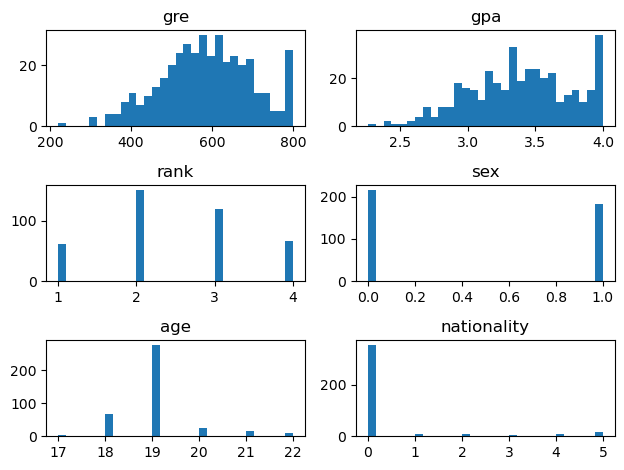

In [61]:
for i in range(df.shape[1]-1): # admisison 칼럼 미표시
    data = np.array(df.iloc[:,i]) #각 열별로 1차원 Array 에 값 저장
    plot.subplot(3,2,i+1)
    plot.hist(data,bins=30)
    plot.title(df.columns[i]) #각 서브플롯별로 Title 을 df의 칼럼명으로 입력
    
plot.tight_layout() #서브플롯별로 겹치지 않게 Layout 설정
plot.show()

#### nationality 열은 비대칭적인 데이터이므로 모델의 정확도에 좋지 않은 영향을 줄 것으로 판단하여 제거하였다. 
#### 추후 오버샘플링, 언더샘플링을 이해하면 적용할 것이다.

In [62]:
## 추후 ONe-HOt Encoding 을 위해 백업
df1 = df.copy()

df = df.drop(['nationality'],axis=1) #nationality
df.head()

,gre,gpa,rank,sex,age,admission
0,380.000000,3.61,3,1,19,0.0
2,800.000000,4.00,1,0,19,1.0
3,586.753115,3.19,4,0,19,1.0
4,520.000000,2.93,4,1,19,0.0
5,760.000000,3.00,2,1,19,1.0


# 4) 의사결정나무 모델 적합

In [63]:
X = np.array(df.iloc[:,:5]) #admission 열 제외 모든 열 집어넣기, 속성값 X로 저장
Y = np.array(df['admission']) #admission 값을 목표변수 Y로 저장
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)

# 4-1-1 ) 최적 나무깊이 찾기 방법 1 : GridSearchCV 사용한 최적값 검색

In [64]:
goukaku = DecisionTreeClassifier(random_state=12345)
grid_goukaku = GridSearchCV(goukaku, params, n_jobs=1)
grid_goukaku.fit(X_train, Y_train)
print(grid_goukaku.best_params_)

{'max_depth': 4, 'min_impurity_decrease': 0.0001, 'min_samples_split': 22}


# 4-1-2 ) 최적 나무깊이 찾기 방법 2 : 1부터 30까지 대입

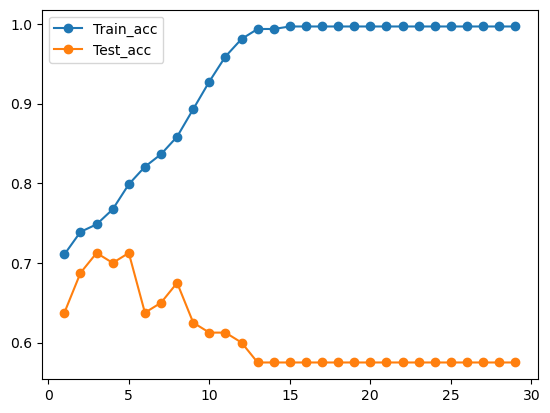

In [65]:
from sklearn.metrics import accuracy_score #정확도 출력을 위한 라이브러리
from matplotlib import pyplot
train_scores, test_scores = list(), list()
for i in range(1,30):
    dt = DecisionTreeClassifier(max_depth=i, random_state=12345)
    dt.fit(X_train, Y_train)
    
    #정확도 평가
    train_att = dt.predict(X_train)
    train_acc = accuracy_score(Y_train, train_att)
    train_scores.append(train_acc) #train_acc를 train_scores 에 추가
    
    # 테스트 데이터셋 정확도 평가
    test_att = dt.predict(X_test)
    test_acc = accuracy_score(Y_test, test_att)
    test_scores.append(test_acc)
    
pyplot.plot(range(1,30), train_scores, '-o', label='Train_acc') #주의! for문으로 서치한 정확도 i 값이랑 range 랑 일치해야함!
pyplot.plot(range(1,30), test_scores, '-o', label='Test_acc')
pyplot.legend()
pyplot.show()

## 4-2) 최적값으로 모델 적합

#### GridSearchCV나 대입방식 두 방법을 통해 최적 나무깊이는 3~5 정도인 것을 알 수 있었다.

In [66]:

admtree = DecisionTreeClassifier(max_depth=5, min_impurity_decrease=0.0001, min_samples_split=22, random_state=12345)
admtree.fit(X_train, Y_train) #모델 적합

DecisionTreeClassifier(max_depth=5, min_impurity_decrease=0.0001,
                       min_samples_split=22, random_state=12345)

## 5) 모델 성능 평가

In [67]:
#모델 성능 종합 평가 모듈 호출
from sklearn.metrics import classification_report
print(classification_report(Y_test, admtree.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81        51
         1.0       0.88      0.24      0.38        29

    accuracy                           0.71        80
   macro avg       0.78      0.61      0.60        80
weighted avg       0.76      0.71      0.66        80



#### 약 71%의 정확도와 약 77%의 정밀도, 61~71%의 재현율을 보임

## 6) 의사결정모델을 통해 결측치 데이터 출력

In [68]:
nulldf

,gre,gpa,rank,sex,age,nationality,admission
1,660.0,3.67,3,1,18,0,NaN
20,500.0,3.17,3,1,19,0,NaN


In [69]:
print(admtree.predict([[660.0,3.67,3,1,18]]))
print(admtree.predict([[500.0,3.17,3,1,19]]))

[0.]
[0.]


#### 합격여부를 알 수 없던 두 학생의 결과는 '불합격'으로 예측되었다.

## 7) 의사결정나무 시각화

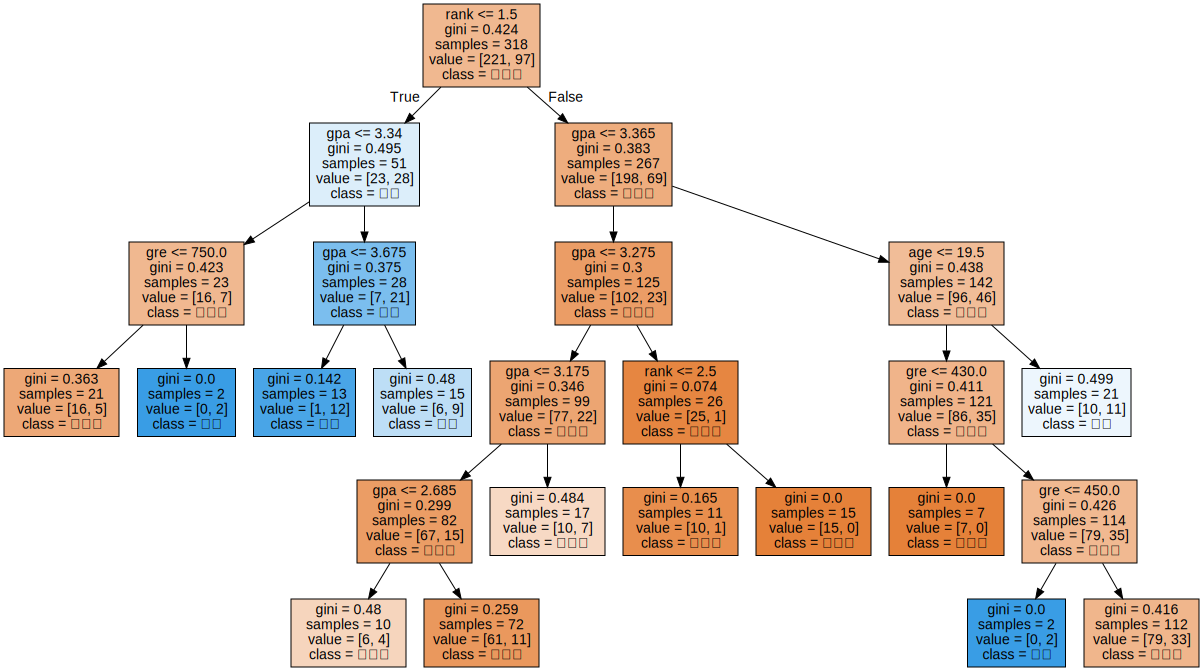

In [70]:
import graphviz
from sklearn.tree import export_graphviz

feature_name=['gre','gpa','rank','sex',
              'age']
tree_graph = export_graphviz(admtree, feature_names=feature_name,
                             class_names=(['불합격','합격']), filled=True)
graphviz.Source(tree_graph)

#### 만약 1번 학생의 나이가 20살이고, 20번 학생의 GPA가 3.365 초과이며 나이가 20살이면 두 학생 다 합격으로 예측되는 결과가 만들어졌다.

In [71]:
print(admtree.predict([[660.0,3.67,3,1,20]]))
print(admtree.predict([[500.0,3.366,3,1,20]]))

[1.]
[1.]


## 7-1) 트리 구조 출력

In [72]:
img = graphviz.Source(tree_graph)
img.format = 'gif'
img.render(filename='student_tree', directory='studentimg', cleanup=True)

'studentimg\\student_tree.gif'

# 8) 후기


##### [의사결정나무]
##### 의사결정나무는 자동으로 gini 계수가 가장 작은 칼럼인 rank 부터 분류하는 것으로 보인다.
##### 의사결정나무에서 1번 학생의 경우 나이가 19.5보다 작아 불합격으로 분류되었고, 20번 학생의 경우 GPA가 3.365 이하라 불합격으로 분류되었다.
##### 의사결정나무의 구조상 불합격으로 치우쳐진 데이터가 많은 것으로 보인다.
##### 의사결정나무의 깊이가 3 초과일 경우 불순도의 감소량이 매우 작고 5단계에서 분류된 데이터도 적었기에 나무의 깊이는 3정도가 적절하다는 결과도 해석할 수 있었다.
##### 
##### [결측치 보간법에 대한 이해 부족]
##### gpa와 gre 값의 상관관계를 통해 결측치를 채우고 싶어 선형회귀모델을 사용하였다. 하지만 그 전에 선형보간법과 그룹후 중간값으로 채우기 등 여러 결측치 보간법을 시도해 보았다. gpa 와 gre 의 경우 학생 Index 값에 따라 값이 linear 하게 연속되지 않기에 Interpolate 함수의 linear 옵션을 사용하지 않았다. 아직 모르는 보간법이 많아 이를 적극적으로 적용하는 데 한계가 있었다.
##### 선형회귀모델을 적용하는 데 있어 admission 값이 없는 레코드를 임의로 1로 지정하였다. admission 값은 boolean 이지만 결측치를 중간값인 0.5 정도로 두는 것도 좋은 방법같다.
##### 
##### [낮은 모델의 정확도]
##### 결측치를 정성들여 채우고 GridSearchCV 와 대입검증으로 최적 모델을 찾아냈음에도, 테스트데이터로 모델성능을 확인했을 때 기대보다 적은 정확도를 보여줬다. ##### 이는 의사결정모델의 한계로 gpa과 gre값이 연속적이기에 그 경계선에 있는 레코드를 분류하기 어려운 부분이 있기 때문이며 그 외에도 상정하지 못한 변수가 있을 것이라 생각된다.
##### 이번에는 nationalty 칼럼의 데이터가 극도로 불균형하여 이 칼럼을 제외시켰는데. 추후 오버샘플링을 통해 한국 외 다른 국적의 레코드를 증폭시키면 모델 정확도도 올리고 다양한 데이터를 구분할 수 있는 모델이 만들어질 것 같다.
##### 
##### [도메인 지식으로 전처리하는 것의 한계]
##### 도메인 지식으로 생각했을 때 nationality 값은 제거해야 했으며, gpa, gre 값은 선형회귀모델로 처리하는 것이 맞다고 생각하였다. 덕분에 student.csv 파일의 모든 데이터를 버리지 않고 활용할 수 있었지만 좋은 결과를 보여주지 못해 아쉬웠다.
##### 
##### [데이터프레임의 결측치를 선형회귀모델의 예측값으로 채우는 것이 어려웠다.]
##### 아직 데이터프레임 명령어를 다루는 것이 익숙하지 않아 선형회귀모델에 데이터프레임의 속성값을 한줄씩 가져와 결측치값에 대입하는 방법을 알아내지 못하였다. Series 형식과 Flatten 함수를 통해 2D array 를 1D로 변환해 우회적으로 데이터프레임의 결측치를 선형회귀모델로 채우는 데 성공했지만 더욱 효율적인 구조로 진행하는 방법을 알아봐야겠다.